# Модель стоимости жилья в Магнитогорске

**id для демонстрации на собеседовании**
id = 3, 37, 82

## Введение

**Задача**

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.


Модель должна иметь REST API. На вход модели подаются параметры квартиры в формате JSON на выходе получается цена квартиры в формате JSON.

Испытание проводится в режиме демонстрации экрана на собеседовании. Модель тестируется на 3х квартирах на выбор кандидата. (Просьба подготовить исходные данные (запросы) заранее)


**Данные**


В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru.

Размер выборки исходных данных не имеет значения, однако она должна быть представительной (не следует делать ее слишком большой, т.к. задача тестовая).

Данные должны быть загружены в базу данных.

## Импорт библиотек и загрузка данных

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
, 
RANDOM_STATE = 12345

In [2]:
# подключаемся к базе данных
cnx = sqlite3.connect('db/magnitogorsk.db')

In [3]:
# загружаем данные
data = pd.read_sql_query("SELECT * FROM offers", cnx)

In [4]:
# закрываем соединение с базой данных
cnx.close()

## Первичное знакомство с данными

In [5]:
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [6]:
first_look(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              456 non-null    int64  
 1   type            445 non-null    object 
 2   district        254 non-null    object 
 3   adress          456 non-null    object 
 4   floor           456 non-null    object 
 5   total_square    456 non-null    float64
 6   living_square   456 non-null    float64
 7   kitchen_square  456 non-null    float64
 8   price           456 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 32.2+ KB


None

Первые 5 строк(и) данных


,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800


Основные статистические характеристики данных


,id,total_square,living_square,kitchen_square,price
count,456.00000,456.000000,456.000000,456.000000,456.000000
mean,228.50000,53.514912,32.120175,8.771250,3744.561404
std,131.78012,21.751910,17.343334,4.007841,1631.107124
min,1.00000,14.100000,0.000000,0.000000,0.000000
25%,114.75000,40.175000,19.000000,6.000000,2700.000000
50%,228.50000,50.000000,30.000000,8.050000,3500.000000
75%,342.25000,65.000000,43.000000,10.000000,4600.000000
max,456.00000,220.000000,150.000000,30.000000,10000.000000


Количество пропусков:
id                  0
type               11
district          202
adress              0
floor               0
total_square        0
living_square       0
kitchen_square      0
price               0
dtype: int64

Количество дубликатов: 0


Посмотрим, есть ли в данных дубликаты, если мы не будем учитывать столбец id.

In [7]:
print('Количество дубликатов:', data.drop('id', axis=1).duplicated().sum())

Количество дубликатов: 2


In [8]:
data[data.drop('id', axis=1).duplicated()]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
354,355,Двухкомнатная раздельная,Орджоникидзевский (левый берег),Трамвайная 25,1/3,43.0,31.0,6.0,2350
413,414,Двухкомнатная,Правобережный,"Им. газеты ""Правда"" 23",4/5,46.1,29.0,6.0,2600


In [9]:
data.shape

(456, 9)

In [10]:
data.drop_duplicates(
    subset=['type', 'district', 'adress', 'floor', 'total_square', 'living_square', 'kitchen_square', 'price'],
    inplace=True
)

In [11]:
data.shape

(454, 9)

### Цена

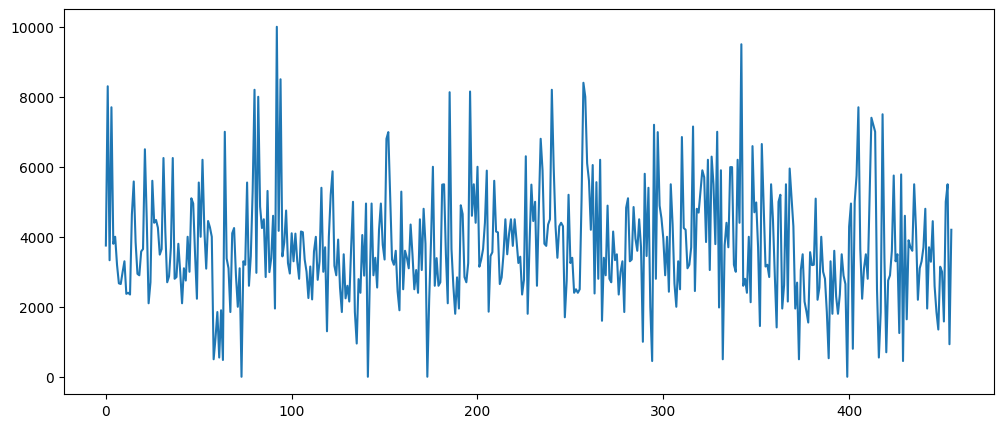

In [12]:
data['price'].plot(figsize=(12, 5));

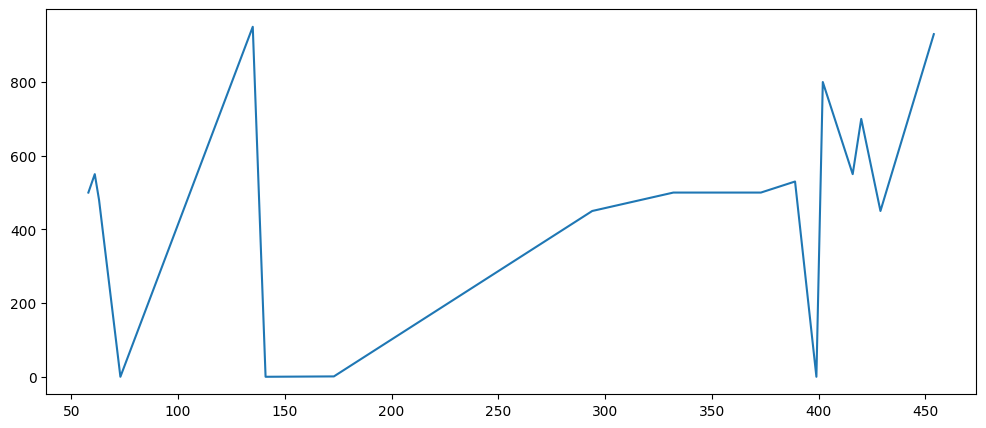

In [13]:
data[data['price'] < 1000]['price'].plot(figsize=(12, 5));

In [14]:
data[data['price'] < 800].shape[0] / data.shape[0] * 100

3.0837004405286343

In [15]:
data[data['price'] < 600]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
58,59,Трехкомнатная,None,Школьная 10,1/1,59.5,47.0,12.0,500
61,62,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,550
63,64,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,480
73,74,Однокомнатная,None,Первомайская 16,2/4,42.6,20.0,15.0,0
141,142,Однокомнатная,None,Труда 47,4/9,32.0,19.0,6.0,0
173,174,Однокомнатная малосемейка,Правобережный,Советской Армии 37/1,4/9,22.0,12.0,6.0,1
294,295,Однокомнатная,None,Привокзальная 29кв1,1/1,42.5,22.0,12.0,450
332,333,Двухкомнатная,None,Российская 7,2/2,45.0,31.0,6.0,500
373,374,Двухкомнатная,None,ул Черемушки 13,2/2,40.0,22.0,6.0,500
389,390,Трехкомнатная,None,Труда 2,1/2,63.4,0.0,0.0,530


Для трех квартир цена не указана, поэтому удалим эти строки, так как они не подходят ни для обучения модели ни для контроля качества. 

Количество квартир с нетипично низкой ценой составляет около 3 % данных. Удалим их, чтобы модель смогла точнее выявить закономерность.

In [16]:
# контроль размерности
data.shape

(454, 9)

In [17]:
data = data[data['price'] >= 800]

In [18]:
# контроль размерности
data.shape

(440, 9)

### Этаж

In [19]:
data['floor'].isna().sum()

0

Первоначально генерировала характеристики «первый этаж», «последний этаж». Но после анализа работы лучшей модели, выяснилось, что эти характеристики в рейтинге полезности заняли последние места, а модель, обученная без них, дает более высокие оценки.

### Тип квартиры

В столбце с типом квартиры хранятся данные о количестве комнат и типе квартиры. Разделим их и сохраним в двух разных столбцах.

In [20]:
data['type'].isna().sum()

11

In [21]:
data['type'].isna().sum() / data.shape[0] * 100

2.5

In [22]:
data[data['type'].isna()]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
59,60,None,None,Ленина пр-т 212а,1/1,18.4,12.0,5.0,1100
83,84,None,None,Карла Маркса 233,8/10,70.0,50.0,7.0,4860
97,98,None,Орджоникидзевский,Завенягина 1,5/9,65.1,44.0,8.0,4750
140,141,None,None,Торфяная 5/2,1/2,46.8,0.0,0.0,4950
161,162,None,None,Карла Маркса 119/1,2/5,41.0,0.0,6.0,3600
162,163,None,None,Карла Маркса 117,2/5,41.0,26.0,6.0,3400
163,164,None,None,ул Жукова 17/1,4/9,40.1,18.0,9.0,3100
176,177,None,None,Западное шоссе 101,2/3,68.0,40.0,0.0,6000
355,356,None,None,ул Лесопарковая 93/1,10/10,41.2,28.0,12.5,3150
365,366,None,None,Ленина пр-т 114/4,5/14,40.0,18.0,13.0,2620


In [23]:
data = data[data['type'].notna()]

### Улица

In [24]:
data[data['adress'] == ' '].shape

(4, 9)

In [25]:
data = data[data['adress'] != ' ']

In [26]:
# sorted(data['adress'].unique())
data['adress'].nunique()

366

### Район

Посмотрим количество пропусков в столбце с данными о районе.

In [27]:
data['district'].isna().sum()

176

Заполним пропуски значением 'неизвестно'.

## Построение модели

### Предварительна обработка данных

Разделим характеристики и целевую переменную.

In [28]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800


In [29]:
features = data.drop(['id', 'price'], axis=1)
target = data['price']

In [30]:
features.head()

,type,district,adress,floor,total_square,living_square,kitchen_square
0,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0
1,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0
2,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0
3,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0
4,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0


In [31]:
target.head()

0    3750
1    8300
2    3330
3    7700
4    3800
Name: price, dtype: int64

### Трансформер для предварительной обработки данных

Напишем два трансформера для предварительной обработки данных

**Чистка данных**
- 'adress': у названий улиц уберем номера домов
- 'adress': в названиях улиц исправим неявные дубликаты
- 'district': исправим неявные дубликаты

**Преобразование характеристик**
    
- 'floor': добавляем столбец с номером этажа
- 'floor': добавляем столбец с общим количеством этажей в доме.
- 'type': добавляем столбец с количеством комнат
- 'type': добавляем столбец с типом планировки. пропуски заполняем значением «неизвестно»
- 'floor': удалим, потому что вместо него будем использовать столбцы, сгенерированные на его основе 
- 'type': удалим, потому что вместо него будем использовать столбцы, сгенерированные на его основе 
- 'adress': удалим, потому что вместо него будем использовать столбцы, сгенерированные на его основе


In [32]:
class DataCleaner(BaseEstimator, TransformerMixin):
    '''
    Класс для обработки неявных дубликатов и пропусков
    '''
    def __init__(self):
        self.districts_to_replace = {
            'ленинский' : 'Ленинский',
            'Орджоникидзевский район' : 'Орджоникидзевский',
            'Орджо' : 'Орджоникидзевский',
            'правобережный' : 'Правобережный'
        }
        self.streets_to_replace = {
            'зеленый лог' : 'Зеленый Лог',
            'Зеленый лог' : 'Зеленый Лог',
            'Зеленый лог 30 к' : 'Зеленый Лог',
            'Им. газеты \\"Правда\\"' : 'имени газеты Правда',
            'Им. газеты "Правда"' : 'имени газеты Правда',
            'проспект Сиреневый' : 'Сиреневый проезд',
            'карла маркса' : 'Карла Маркса',
            '50 лет Магнитки' : '50-летия Магнитки',
            'Ленина пр-т 210' : 'Ленина пр-т',
            'Советский переулок 12' : 'Советский переулок',
            '26 Горнолыжная' : 'Горнолыжная'
        }
        
    def __get_street(self, row):
        dirt = ['ул. ', 'ул.', 'ул ', 'пр.']
        for dot in dirt:
            if dot in row:
                row = row.replace(dot, '')
        if row.find('. ') == 0:
            row = row[2:]
        return row[: row.rfind(' ')]
    
    def fit(self, X):
        return self

    def transform(self, X):
         
        # обработка дубликатов и пропусков района
        X['district'].replace(to_replace=self.districts_to_replace, inplace=True)
        X['district'].fillna('неизвестно', inplace=True)
        
        # обработка дубликатов улиц
        X['adress'] = X['adress'].apply(self.__get_street)
        X['adress'].replace(to_replace=self.streets_to_replace, inplace=True)
                        
        return X

In [33]:
class FeaturesTransformer(BaseEstimator, TransformerMixin):
    '''
    Класс для преобразования характеристик.
    
    Добавляет:
        floor_num - номер этажа
        total_floors - общее количество этажей
        num_of_rooms - количество комнат
        flat_type - тип планировки

    Удаляет: 
        floor - так как заменен на два более информативных признака
        type - так как заменен на два более информативных признака
    '''
    columns_ = [
        'district', 
        'adress', 
        'total_square', 
        'living_square', 
        'kitchen_square', 
        'floor_num', 
        'total_floors', 
        'num_of_rooms', 
        'flat_type'
    ]
    def __init__(self):
        pass
        
    def __get_floor_num(self, row):
        return int(row[:row.find('/')])
    
    def __get_total_floors(self, row):
        return int(row[row.find('/')+1:])

    def __get_num_of_rooms(self, row):
        return row[: row.find(' ')] if row.find(' ') > 0 else None

    def __get_flat_type(self, row):
        return 'неизвестно' if (len(row) - row.find(' ') == 1) or (row.find(' ') == -1) else row[row.find(' ')+1:]
    
    def fit(self, X):
        return self

    def transform(self, X):
         
        # номер этажа квартиры
        floor_num = X['floor'].apply(self.__get_floor_num)

        # общее количество этажей в доме
        total_floors = X['floor'].apply(self.__get_total_floors)

        num_of_rooms = X['type'].apply(self.__get_num_of_rooms)
        flat_type = X['type'].apply(self.__get_flat_type)
        
        X = pd.DataFrame(np.c_[X.drop(['floor', 'type'], axis=1), floor_num, total_floors, num_of_rooms, flat_type])    
        X.columns = self.columns_
        return X

Выделим категориальные и числовые признаки.

### Подготовка обучающей и валидационной выборки.

Выделим характеристики, которые будем использовать для обучения модели.

|столбец|комментарий|
|:--|:--|
|id|не влияет на цену квартиры|
|type|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|**district**|может оказывать влияние|
|**adress**|может оказывать влияние|
|floor|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|**total_square**|может оказывать влияние|
|**living_square**|может оказывать влияние|
|**kitchen_square**|может оказывать влияние|
|**price**|целевой признак|
|**floor_num**|может оказывать влияние|
|**total_floors**|может оказывать влияние|
|**num_of_rooms**|может оказывать влияние|
|**flat_type**|может оказывать влияние|

Разобьем выборки на обучающую и валидационную в отношении 4 : 1.

In [34]:
features_train, features_val, target_train, target_val = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [35]:
numeric = ['total_square', 'living_square', 'kitchen_square',
       'floor_num', 'total_floors']
categorical = ['district', 'adress', 'num_of_rooms', 'flat_type']

Количество комнат попадает в категориальные признаки, потому что содержит значение «многоквартирная», которое нельзя заменить конкретным числовым значением.

Преобразуем категориальные признаки в числа с помощью порядкового кодирования. 

In [36]:
# my_pipeline[1].columns_

In [37]:
my_pipeline = Pipeline([
    ('data_cleaner', DataCleaner()),
    ('features_transformer', FeaturesTransformer()),
    ('col_transformer', ColumnTransformer(
   transformers=[
       ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), categorical)
       ],
    remainder="passthrough",
    verbose_feature_names_out=False
)),
    ('scaler', StandardScaler())
])

In [38]:
features_train_piped = pd.DataFrame(my_pipeline.fit_transform(features_train))

In [39]:
features_val_piped = pd.DataFrame(my_pipeline.transform(features_val))

In [40]:
features_train_piped.columns = categorical + numeric
features_train_piped

,district,adress,num_of_rooms,flat_type,total_square,living_square,kitchen_square,floor_num,total_floors
0,1.025638,-1.587622,0.277145,-0.360087,-1.431076,-1.115889,-0.963241,0.839670,0.813310
1,1.025638,-0.667000,0.277145,-0.360087,-0.232604,-1.286261,3.935852,0.075312,0.813310
2,-0.809714,-1.434185,1.037059,-1.790338,0.228347,0.587835,-0.473332,0.457491,0.813310
3,-1.421498,-1.229602,-1.242682,1.928315,0.652422,0.241411,0.506487,-0.689046,-1.279314
4,1.025638,0.765079,1.037059,-0.360087,0.551012,-1.797378,0.016578,-0.689046,0.813310
...,...,...,...,...,...,...,...,...,...
335,0.413854,0.918516,-1.242682,-1.790338,-0.416984,-0.150445,-0.473332,0.457491,-0.382475
336,1.025638,-0.411271,0.277145,-0.360087,-0.831840,-0.661562,-1.208196,0.075312,-0.382475
337,1.025638,-0.411271,0.277145,-0.360087,-1.408028,-0.945516,-0.963241,-0.689046,-0.382475
338,-1.421498,0.202477,0.277145,1.642265,-0.924030,-0.661562,-0.473332,-0.306867,-0.382475


In [41]:
features_val_piped.columns = categorical + numeric
features_val_piped

,district,adress,num_of_rooms,flat_type,total_square,living_square,kitchen_square,floor_num,total_floors
0,1.025638,-1.025019,0.277145,-0.360087,-0.601364,-0.661562,0.016578,-0.306867,0.813310
1,-0.809714,-0.360126,-1.242682,-0.360087,0.444994,0.814998,-0.105900,1.221849,1.112256
2,1.025638,-0.411271,1.037059,-0.360087,1.703389,1.610069,-0.473332,-0.689046,-1.279314
3,-1.421498,0.151331,1.037059,-0.074037,0.965868,1.382906,0.016578,0.457491,-0.382475
4,0.413854,0.509351,-1.242682,-0.360087,-0.440032,-0.264027,-0.718286,0.075312,-0.382475
...,...,...,...,...,...,...,...,...,...
80,-1.421498,0.100185,-1.242682,1.928315,0.320537,0.019927,0.016578,-1.071225,-0.681422
81,1.025638,0.816225,-1.242682,-0.360087,-0.163461,0.019927,-0.105900,0.075312,0.813310
82,-0.809714,-1.792204,1.037059,-1.790338,0.689298,0.758207,-0.718286,0.457491,-0.382475
83,-0.809714,-0.360126,0.277145,-0.074037,-0.587536,-0.661562,0.016578,2.368386,1.112256


In [42]:
target_train = target_train.reset_index(drop=True)

In [43]:
target_val = target_val.reset_index(drop=True)

Модель линейной регрессии

In [44]:
class MyLinearRegression:
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [45]:
# наша модель
model_1 = MyLinearRegression()
model_1.fit(features_train_piped, target_train)
predictions = model_1.predict(features_val_piped)

# метрика MAE
mae = mean_absolute_error(target_val, predictions)
print(mae)

664.8244052685571


In [46]:
target_val

0     3050
1     5950
2     7400
3     5500
4     2650
      ... 
80    3840
81    3400
82    4130
83    3300
84    6200
Name: price, Length: 85, dtype: int64

In [47]:
for i in range(10):
    print(target_val.iloc[i], predictions.iloc[i])

3050 3267.7070993571897
5950 4533.4168818013895
7400 5549.792917958559
5500 5159.7563727256
2650 3027.4608064842996
3000 3266.5331128096204
4200 4476.107689289267
2800 2722.296552297572
4300 4759.778454810906
2750 4623.611591793881


In [48]:
from sklearn.tree import DecisionTreeRegressor

In [49]:
DTR = DecisionTreeRegressor(
    max_depth=10,
    random_state=RANDOM_STATE
)

In [50]:
DTR.fit(features_train_piped, target_train)

DecisionTreeRegressor(max_depth=10, random_state=12345)

In [51]:
predictionsDTR = DTR.predict(features_val_piped)

# метрика MAE
maeDTR = mean_absolute_error(target_val, predictionsDTR)
print(maeDTR)

565.4717647058824


In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
# список гиперпараметров и их значений
search_space = {
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [5, 10, 15],
    'n_estimators' : [50, 100, 200],
    'max_features' : ['sqrt', 'log2', 1]
}

In [54]:
model_rfr = RandomForestRegressor(
    random_state=RANDOM_STATE
)

In [55]:
GS = GridSearchCV(
    estimator=model_rfr,
    param_grid=search_space,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=4
)

In [56]:
# GS.fit(features_train_sc, target_train)

In [57]:
# GS.best_score_

In [58]:
# GS.best_estimator_

In [59]:
RFR = RandomForestRegressor(
    # criterion='poisson',
    max_depth=10, 
    # max_features='sqrt',
    n_estimators=100,
    random_state=RANDOM_STATE
)

In [60]:
# RFR = RandomForestRegressor(
#     max_depth=10,
#     random_state=RANDOM_STATE,
#     n_estimators=100
# )

In [61]:
RFR.fit(features_train_piped, target_train)

RandomForestRegressor(max_depth=10, random_state=12345)

In [62]:
predictionsRFR = RFR.predict(features_val_piped)

# метрика MAE
maeRFR = mean_absolute_error(target_val, predictionsRFR)
print(maeRFR)

489.68761813934765


In [63]:
mean_absolute_percentage_error(target_val, predictionsRFR)*100

14.551127744777027

In [64]:
mean_squared_error(target_val, predictionsRFR) ** 0.5

722.3377981485312

In [65]:
for i in range(10):
    print(target_val.iloc[i], predictionsRFR[i])

3050 3037.532532992569
5950 5041.795213952713
7400 6043.4
5500 5616.993880447037
2650 3138.790570373176
3000 2618.297596453667
4200 4224.286746031746
2800 2510.6049428326864
4300 4685.249626557652
2750 4666.16429197995


In [66]:
len(target_val)

85

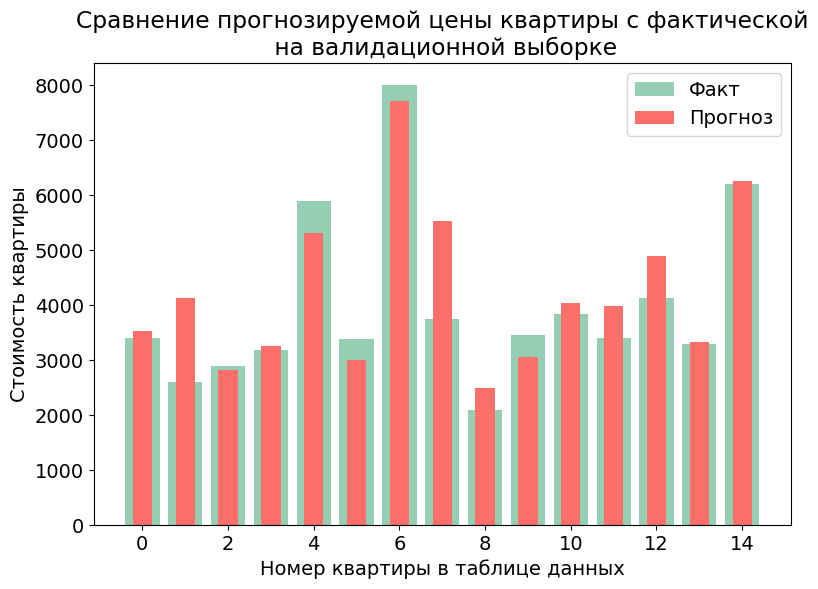

In [71]:
# построим диаграмму значений
fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('font', size=14)
x = [i for i in range(15)]

ax.bar(x, target_val[70:], color='#96ceb4', label='Факт')
ax.bar(x, predictionsRFR[70:], width = .45, color='#ff6f69', label='Прогноз')
# ax.plot(x, [y_test[:13].median() for i in range(13)], color='#36454f', label='Медиана')



ax.set_ylabel('Стоимость квартиры')
ax.set_xlabel('Номер квартиры в таблице данных')

ax.set_title('Сравнение прогнозируемой цены квартиры с фактической\n на валидационной выборке')
ax.legend()
fig.savefig('price_val_chart.png')
plt.show()

In [72]:
sorted(zip(RFR.feature_importances_, features_val_piped.columns), reverse=True)

[(0.787584286225009, 'total_square'),
 (0.0490937542742821, 'kitchen_square'),
 (0.036396633086722904, 'total_floors'),
 (0.032477253890963724, 'living_square'),
 (0.028734086724948028, 'adress'),
 (0.02301100845566197, 'num_of_rooms'),
 (0.02004651697353978, 'floor_num'),
 (0.012174181488267644, 'district'),
 (0.01048227888060481, 'flat_type')]

## Запуск модели на предсказаниях в формате JSON

In [74]:
data.drop(['id', 'price'], axis=1).iloc[10].to_json('test_features.json')

In [76]:
test_1 =  pd.read_json('test_features.json', typ='series')
test_1

type              Однокомнатная нестандартная
district                    Орджоникидзевский
adress                      Ленина пр-т 133/1
floor                                   10/10
total_square                             40.3
living_square                            20.0
kitchen_square                            9.0
dtype: object

In [78]:
test_1 = test_1.to_frame().T

In [79]:
my_pipeline.transform(test_1)

array([[-0.80971406, -0.36012566,  0.27714497, -0.07403652, -0.58753595,
        -0.66156244,  0.01657767,  2.36838619,  1.11225609]])

In [80]:
RFR.predict(my_pipeline.transform(test_1))[0]

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


3372.1845027195027

In [81]:
data['price'].iloc[10]

3300

In [82]:
with open ('pickle/pipeline-1.0.pkl', 'wb') as f:
    pickle.dump(my_pipeline, f)

In [83]:
with open ('pickle/model-1.0.pkl', 'wb') as f:
    pickle.dump(RFR, f)